## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [1]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/ufo-prediction', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4x1rkp8r because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
# # When loading ufo data
# #DATA_DIR = '.'
# current_directory = os.getcwd()
# print(current_directory)

# path_data_NLD = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-NLD.pkl')
# path_data_FRA = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-FRA.pkl')
# path_data_ESP = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-ESP.pkl')
# print(path_data_NLD)
# df = pd.read_pickle(path_data_NLD)


/workspace
/workspace/workspace/ufo-prediction/demo/df-NLD.pkl


In [3]:
path_data_NLD = os.path.join(dataset.DATA_DIR, 'ufo-CNN_ALL.csv')
df = pd.read_csv(path_data_NLD, encoding='latin1')

In [4]:
df['age']

0       1900.0
1       1914.0
2       1987.0
3       1990.0
4       1992.0
         ...  
2212    1900.0
2213    1900.0
2214    2006.0
2215    1934.0
2216    1900.0
Name: age, Length: 2217, dtype: float64

In [5]:
df.drop(columns=['Predicted Class', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6'])

,id,source_file,dist_to_closest_int,av_footprint_area_within_buffer_100,street_betweeness_global_max_within_buffer_500,av_elongation_within_buffer_500,geometry,std_building_footprint_city,block,blocks_2_to_4,...,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood,_merge
0,v0.1-NLD.1.10_1-23813,NL_lod12_2d_pand_2,35.407830,91.483858,0.215399,0.606992,POINT (4087864.200558075 3348246.897434039),343.163256,e8e06078,2801.0,...,0.213489,[23813],0.121355,9.425303e+05,2.917612e+06,0.374833,6.557211e+06,NaN,5efa9783,both
1,v0.1-NLD.1.1_1-13961,NL_lod12_2d_pand_2,113.072803,123.112232,0.029438,0.664662,POINT (4096714.803616596 3319073.5024625),318.422938,0da2c066,2369.0,...,0.012371,[13961],0.338496,1.013007e+06,2.966798e+06,0.549546,5.005234e+05,NaN,409b3089,both
2,v0.1-NLD.1.2_1-1039,NL_lod12_2d_pand_2,11.345041,47.962722,0.071705,0.634149,POINT (4090873.124284167 3328853.3149364046),386.512231,1397442e,5907.0,...,0.058482,"[1039, 12026, 28384, 13168, 12010, 15736, 3252...",0.340041,7.084962e+05,3.936964e+06,0.536083,2.595102e+06,NaN,08bd71fe,both
3,v0.1-NLD.1.2_1-28100,NL_lod12_2d_pand_2,13.526472,61.850977,0.037916,0.647729,POINT (4092043.1248707958 3329176.742017297),386.512231,2d28c8a6,5907.0,...,0.019194,"[4270, 20420, 37943, 38549, 19384, 30543, 2708...",0.416923,7.084962e+05,3.936964e+06,0.479847,7.172781e+05,NaN,cb92baa3,both
4,v0.1-NLD.1.2_1-28896,NL_lod12_2d_pand_2,19.515445,67.205277,0.037511,0.647023,POINT (4092072.623289095 3329207.9361427436),386.512231,0e76ccd5,5907.0,...,0.019194,"[546, 28896]",0.424387,7.084962e+05,3.936964e+06,0.472885,6.581777e+05,NaN,cb92baa3,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,v0.1-FRA.9.2.2.1_1-4050,BATIMENT-normandie,10.381931,55.343446,0.174614,0.604793,POINT (3655410.916911255 2899442.6550018988),193.976804,c7e76bad,1858.0,...,0.064984,"[607, 4050, 610, 611, 12952, 4082, 708, 1739]",0.365220,6.883430e+05,1.322367e+06,0.483004,1.450721e+06,residential,72817831,both
2213,v0.1-FRA.9.2.2.2_1-10984,BATIMENT-normandie,9.213573,71.271983,0.120086,0.593631,POINT (3659460.8024031995 2912521.813943863),230.627649,119c270c,2204.0,...,0.120031,"[709, 10980, 13217, 10978, 10979, 13078, 10981...",0.346466,8.758703e+05,1.826829e+06,0.470041,4.074312e+05,residential,d33b80a2,both
2214,v0.1-FRA.9.2.2.8_1-16086,BATIMENT-normandie,26.837972,108.783755,0.135342,0.605994,POINT (3675996.4861760587 2919267.62146215),518.091045,f896799b,2603.0,...,0.080749,[16086],0.353431,4.116528e+05,2.715634e+06,0.584622,5.525547e+05,residential,cd09e20c,both
2215,v0.1-FRA.9.3.2.13_1-8138,BATIMENT-normandie,34.703388,220.518946,0.031159,0.662823,POINT (3486446.162759419 3010061.1231127926),426.078700,5c5a56c1,2114.0,...,0.031159,"[8138, 8139]",0.296543,5.448892e+05,2.005410e+06,0.529643,4.248851e+05,residential,9f121c69,both


In [6]:
df = df.rename(columns={'age': 'age_right'})


In [7]:
print(len(df))

2217


## Prediction

In [8]:
# xgb_model_params = {'tree_method': 'hist', 
#                     # 'n_estimators': 500
#                     }
# xgb_hyperparams = {
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'n_estimators': 500,
#     'colsample_bytree': 0.5,
#     'subsample': 1.0,
# }

xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 13,
    'learning_rate': 0.025,
    'n_estimators': 1000,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.5
}

### Regression

2024-08-06 18:49:22,340 | INFO : Dataset length: 2217
2024-08-06 18:49:22,345 | INFO : Dataset allocated memory: 2 MB
2024-08-06 18:49:22,349 | INFO : No abort signal received. Continuing... To abort please create ufo-prediction/metadata/local-2ad40ff1.abort.
2024-08-06 18:49:22,350 | INFO : Dataset standard deviation: 32.21521057788602
2024-08-06 18:49:22,352 | INFO : Dataset mean age: 1963.7970230040596
2024-08-06 18:49:22,352 | INFO : Training dataset length: 1773
2024-08-06 18:49:22,353 | INFO : Test dataset length: 444
2024-08-06 18:49:22,367 | INFO : Test dataset standard deviation after preprocessing: 29.670240238821854
2024-08-06 18:49:22,368 | INFO : Test dataset mean age after preprocessing: 1967.5645933014355
2024-08-06 18:49:22,369 | INFO : Training dataset length after preprocessing: 1688
2024-08-06 18:49:22,369 | INFO : Test dataset length after preprocessing: 418
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_

MAE: 20.06 y
RMSE: 25.88 y
R2: 0.2376
Energy need for heating in kWh/(m²a) R2: nan
Energy need for heating in kWh/(m²a) MAPE: nan


FixedFormatter should only be used together with FixedLocator


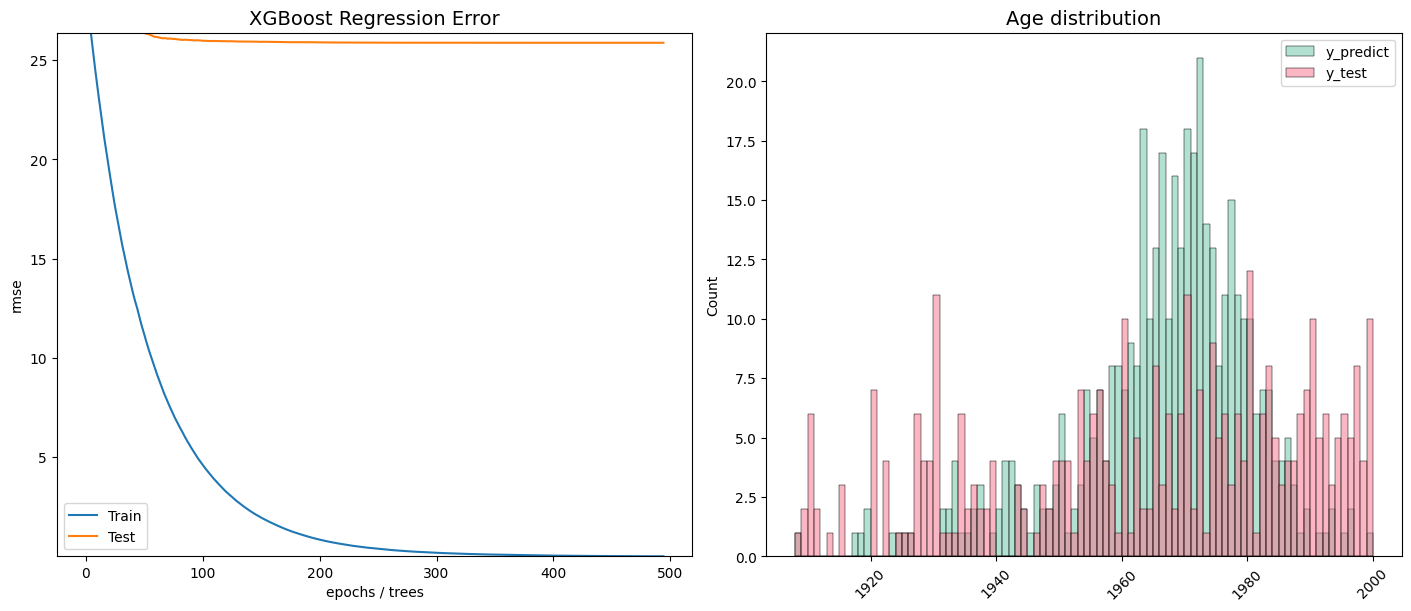

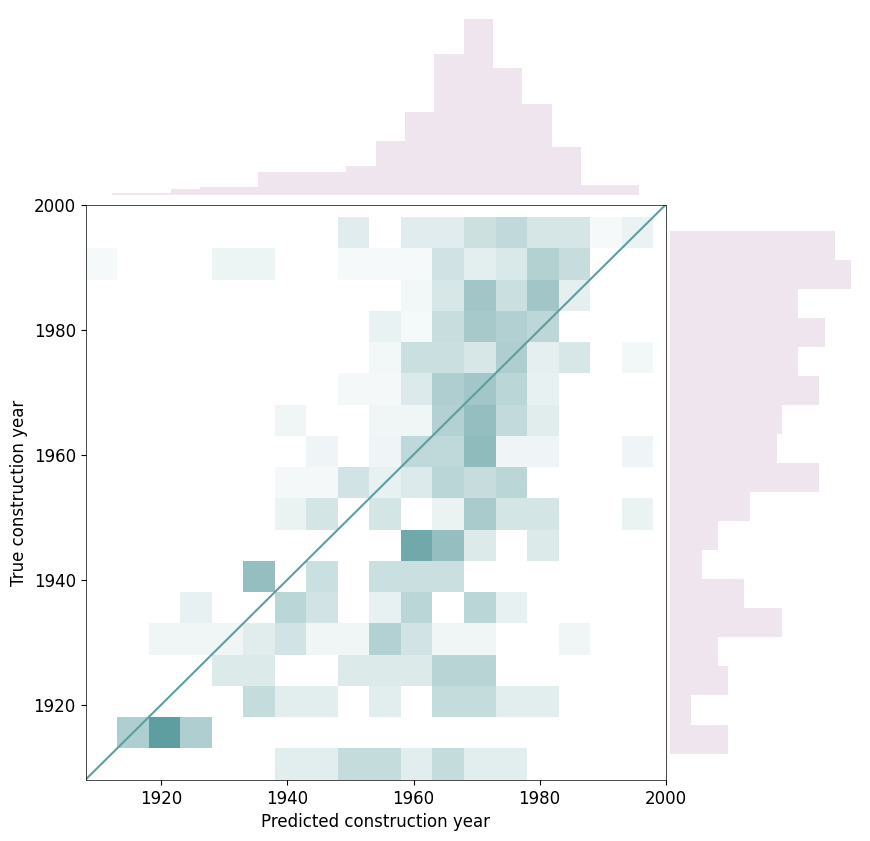

In [9]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    # preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


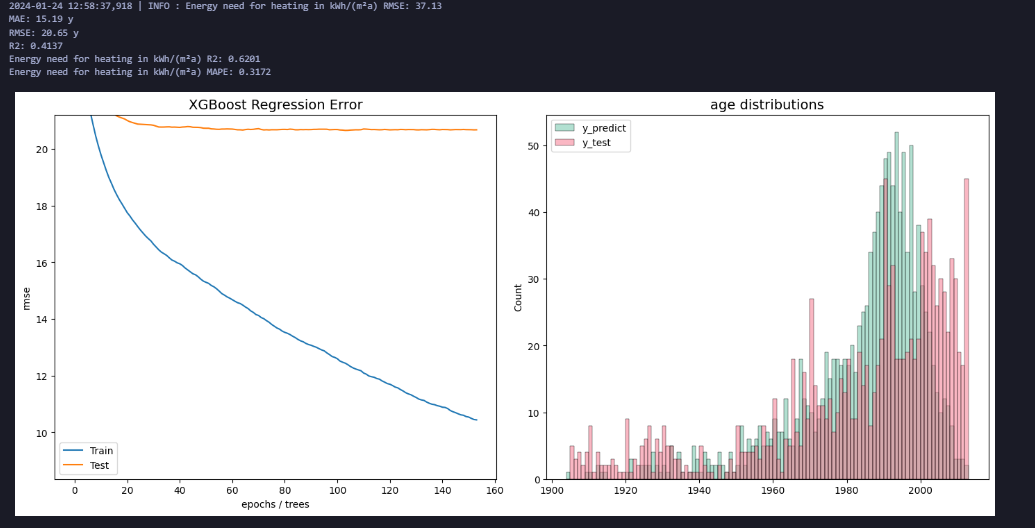
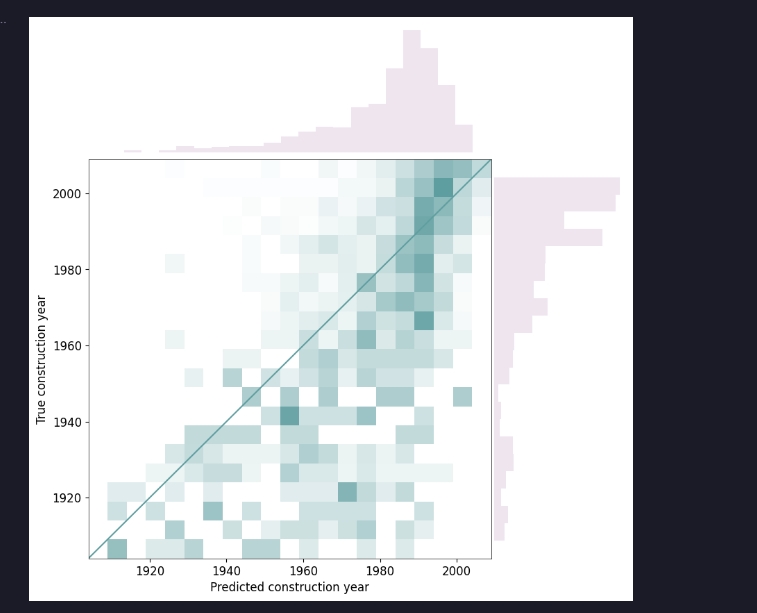

### Classification

2024-08-06 18:49:44,003 | INFO : Generated bins: [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]
2024-08-06 18:49:44,004 | INFO : Generated bins with the following labels: ['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050']
2024-08-06 18:49:44,008 | INFO : Dataset length: 2217
2024-08-06 18:49:44,012 | INFO : Dataset allocated memory: 2 MB
2024-08-06 18:49:44,015 | INFO : No abort signal received. Continuing... To abort please create ufo-prediction/metadata/local-186855e1.abort.
2024-08-06 18:49:44,015 | INFO : Training dataset length: 1773
2024-08-06 18:49:44,016 | INFO : Test dataset length: 444
2024-08-06 18:49:44,017 | INFO : Test cities: ['Horst aan de Maas' 'Sabadell' 'RibamontÃ¡n al Mar' 'Amsterdam'
 'Amstelveen' 'Almelo' 'Sevilla' 'Madrid' 'Venlo' 'Bordeaux'
 'Noord-Beveland' 'Villajoyosa' 'Toulouse' 'A Pobra do CaramiÃ±al' 'Roye'
 'Barcelona' 'Campos' 'Ronda' 'GijÃ³n' 'Waalwijk' 'Purmerend' 'Mauguio'
 'Granada' 'Lesneven' 'Eindhoven' 'L

Classification report:
               precision    recall  f1-score  support
1900-1944      0.518868  0.572917  0.544554       96
1945-1969      0.350649  0.562500  0.432000       96
1970-1979      0.285714  0.185185  0.224719       54
1980-1989      0.520000  0.232143  0.320988       56
1990-1999      0.340000  0.309091  0.323810       55
2000-2009      0.256410  0.227273  0.240964       44
2010-2050      0.222222  0.117647  0.153846       17
accuracy       0.385167  0.385167  0.385167        0
macro avg      0.356266  0.315251  0.320126      418
weighted avg   0.387038  0.385167  0.370542      418
Cohen’s kappa: 0.2427
Matthews correlation coefficient (MCC): 0.2472


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


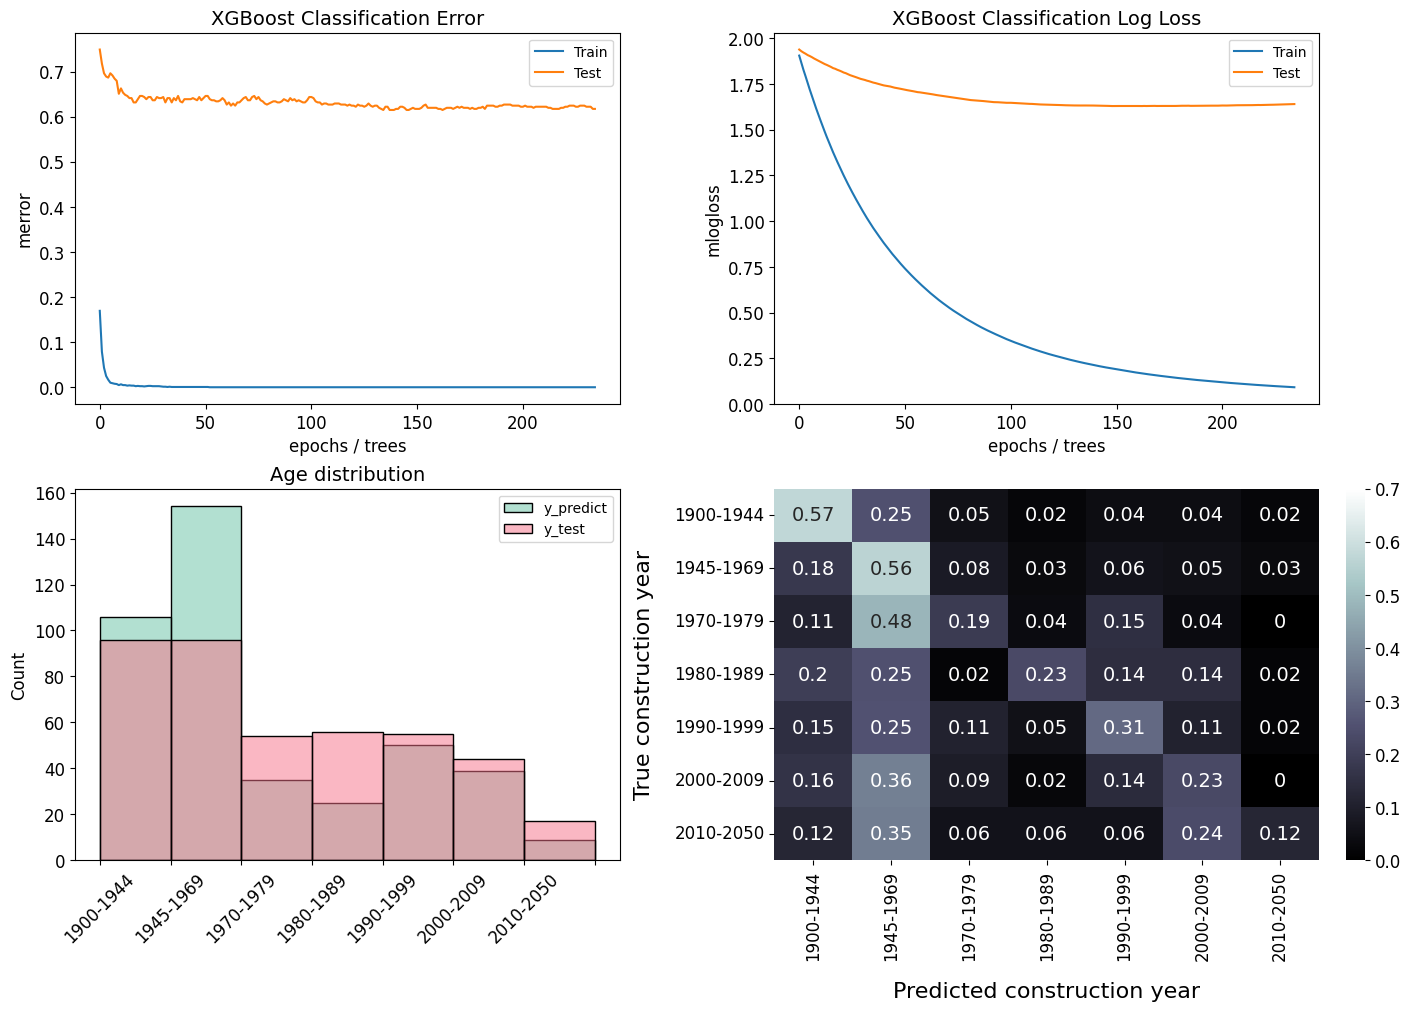

In [10]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=equally_sized_bins,
)
classifier.evaluate(vmax=0.7)

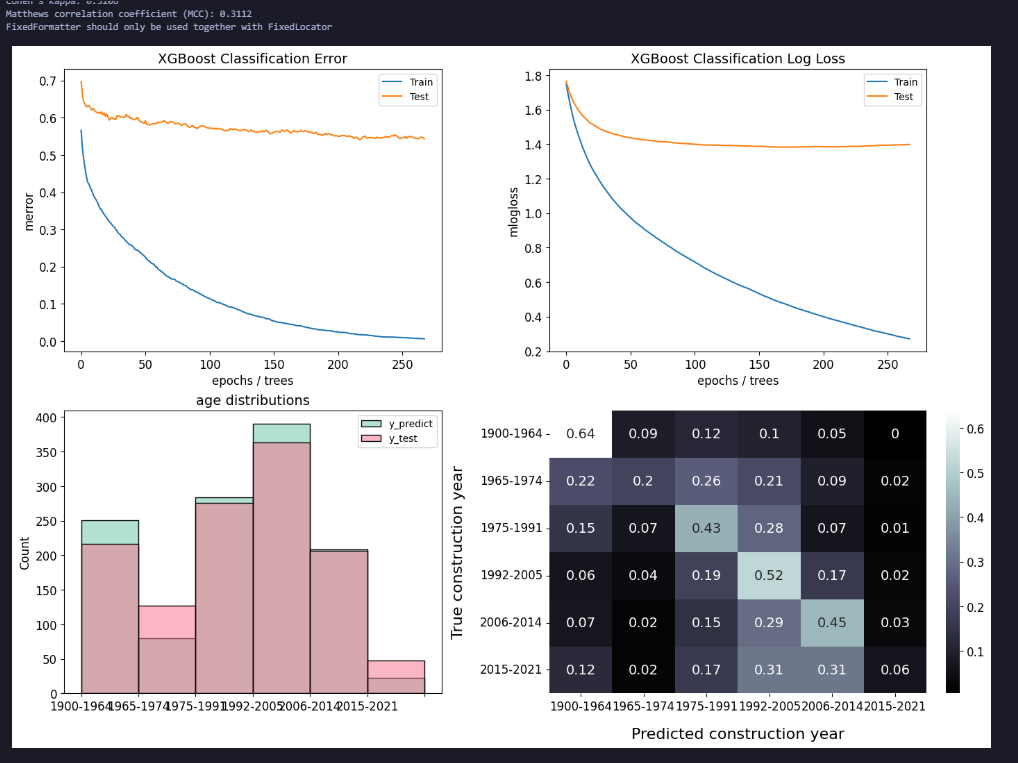

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [21]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2024-01-17 14:50:47,195 | INFO : Starting experiment Spain_random-cv...


2024-01-17 14:53:18,314 | INFO : Dataset length: 4226188
2024-01-17 14:53:18,319 | INFO : Dataset allocated memory: 4385 MB
2024-01-17 14:53:20,237 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-33f2404e.abort.
2024-01-17 14:53:20,256 | INFO : Dataset standard deviation: 48.35942318636823
2024-01-17 14:53:20,263 | INFO : Dataset mean age: 1971.7313162594755
2024-01-17 14:53:20,264 | INFO : Training dataset length: 3380950
2024-01-17 14:53:20,264 | INFO : Test dataset length: 845238
2024-01-17 14:53:33,818 | INFO : Test dataset standard deviation after preprocessing: 25.909066171213233
2024-01-17 14:53:33,820 | INFO : Test dataset mean age after preprocessing: 1980.6306878251494
2024-01-17 14:53:33,821 | INFO : Training dataset length after preprocessing: 3058384
2024-01-17 14:53:33,821 | INFO : Test dataset length after preprocessing: 764264
`early_stopping_rounds` in `fit` method is deprecated for better compatibility

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/workspace/ufo-prediction/demo/df-FRA.pkl'

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_temp, df_temp2, df_dropped
gc.collect()